In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn import tree


In [2]:
# import datasets into dataframes, drop unnecessary columns
game_df = pd.read_csv("game_data.csv", sep=',')
player_df = pd.read_csv("player_data.csv", sep=',')
train_df = pd.read_csv("training_set.csv", sep=',')
test_df = pd.read_csv("test_set.csv", sep=',')
team_df = pd.read_csv("team_data.csv", sep=',')

game_df = game_df[['Season', 'Game_ID', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm', 'Losses_Entering_Gm']]
player_df = player_df[['Season', 'Game_ID', 'Game_Date', 'Team', 'Person_ID', 'Name', 'ASG_Team', 'Active_Status']]


In [3]:
print list(game_df)
print list(player_df)
print list(train_df)
print list(test_df)
print list(team_df)

print test_df[0:3]
print team_df[0:3] # my outside data

['Season', 'Game_ID', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm', 'Losses_Entering_Gm']
['Season', 'Game_ID', 'Game_Date', 'Team', 'Person_ID', 'Name', 'ASG_Team', 'Active_Status']
['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team', 'Country', 'Rounded Viewers']
['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team', 'Total_Viewers']
['Team', 'Market_Size', 'Championships', 'Playoffs', 'Twitter']
    Season   Game_ID   Game_Date Away_Team Home_Team  Total_Viewers
0  2016-17  21600010  10/26/2016       DEN       NOP            NaN
1  2016-17  21600023  10/28/2016       HOU       DAL            NaN
2  2016-17  21600027  10/29/2016       BOS       CHA            NaN
  Team  Market_Size  Championships  Playoffs  Twitter
0  MIL         2255              1         7    0.462
1  GSW         6750              4         5    1.688
2  MIN         4667              0         4    0.458


In [4]:
# major rivalries aquired by Wikipedia
rivalry = [('CLE', 'GSW'), ('BOS', 'LAL'), ('LAL', 'DET'), ('PHI', 'BOS'), ('BOS', 'NYK'), 
           ('NYK', 'BKN'), ('CHI', 'DET'), ('CHI', 'CLE'), ('CHI', 'MIA'), ('CHI', 'NYK'), 
           ('BOS', 'DET'), ('MIA', 'NYK'), ('NYK', 'IND'), ('LAL', 'LAC'), ('DAL', 'HOU'),
           ('HOU', 'SAS'), ('UTA', 'HOU'), ('LAL', 'SAS'), ('SAS', 'PHX')]

# US national holidays
holiday = ['9/3/2016', '10/8/2016', '11/12/2016', '11/22/2016', 
           '11/23/2016', '12/25/2016', '1/1/2017', '1/15/2017', '2/19/2017', 
           '4/16/2017', '5/13/2017', '5/28/2017', '6/17/2017', '7/4/2017', '9/3/2017', 
           '10/8/2017', '11/12/2017', '11/22/2017', '11/23/2017', 
           '12/25/2017', '1/1/2018', '1/15/2018', '2/19/2018', '4/16/2018', 
           '5/13/2018', '5/28/2018','6/17/2018', '7/4/2018']

# NBA regular season first week
first = ['10/25/2016', '10/26/2016', '10/27/2016', '10/28/2016', '10/29/2016',
         '10/30/2016', '10/31/2016', '10/17/2017', '10/18/2017', '10/19/2017',
         '10/20/2017', '10/21/2017', '10/22/2017', '10/23/2017',]

# NBA regular season last two days
last = ['4/11/2017', '4/12/2017', '4/10/2017', '4/11/2018'] 

In [5]:
# create training/test set for 2016 model, we add features to this later
model_train_X = train_df[['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team']].drop_duplicates().reset_index(drop=True) 
model_output_X = test_df[['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team']]

games = list(model_train_X['Game_ID'])
# add up total viewers for each game in training set
model_train_y = []
for game in games:
    model_train_y.append(sum(list(train_df.loc[train_df['Game_ID'] == game]['Rounded Viewers']))) 
    
print len(model_train_X), len(model_train_y), len(model_output_X)


2000 2000 460


In [6]:
# columns to add to train/test sets
cols = ['Home_All_Stars', 'Away_All_Stars', 'Home_Market_Size', 'Away_Market_Size', 
            'Home_Championships', 'Away_Championships', 'Home_Playoffs', 'Away_Playoffs',
            'Home_Twitter', 'Away_Twitter', 'Home_Win_Pct', 'Away_Win_Pct']

model_train_X['Year'] = 0
model_train_X['Rivalry'] = 0
model_output_X['Year'] = 0
model_output_X['Rivalry'] = 0
model_train_X['Day_Code'] = 0
model_output_X['Day_Code'] = 0
model_train_X['Holiday'] = 0
model_output_X['Holiday'] = 0
model_train_X['First'] = 0
model_output_X['First'] = 0
model_train_X['Last'] = 0
model_output_X['Last'] = 0

for c in cols:
    model_train_X[c] = 0.0
    model_output_X[c] = 0.0
    model_train_X[c] = 0.0
    model_output_X[c] = 0.0
    
metrics = ['Market_Size', 'Championships', 'Playoffs', 'Twitter']

def add_features(set_X, num_rows):
    
    i = 0
    games = list(set_X['Game_ID'])
    

    for game in games[0:num_rows]:
        # determine home and away team and winning percentages
        
        h_row = game_df.loc[(game_df['Game_ID'] == game) & (game_df['Location'] == 'H')]
        a_row = game_df.loc[(game_df['Game_ID'] == game) & (game_df['Location'] == 'A')]
        
        h_team = list(h_row['Team'])[0]
        a_team = list(a_row['Team'])[0]
        
        h_win = float(list(h_row['Wins_Entering_Gm'])[0])
        h_loss = float(list(h_row['Losses_Entering_Gm'])[0])
        
        a_win = float(list(a_row['Wins_Entering_Gm'])[0])
        a_loss = float(list(a_row['Losses_Entering_Gm'])[0])
        
        if (h_win + h_loss != 0):
            h_pct = h_win / (h_win + h_loss)
        else:
            h_pct = 0
            
        if (a_win + a_loss != 0):
            a_pct = a_win / (a_win + a_loss)
        else:
            a_pct = 0
    
        # determine home and away active all stars
        h_all_stars = len(player_df.loc[(player_df['Team'] == h_team) 
                                        & (player_df['Game_ID'] == game) 
                                        & (player_df['ASG_Team'] != 'None') 
                                        & (player_df['Active_Status'] == 'Active')])
    
        a_all_stars = len(player_df.loc[(player_df['Team'] == a_team) 
                                        & (player_df['Game_ID'] == game) 
                                        & (player_df['ASG_Team'] != 'None') 
                                        & (player_df['Active_Status'] == 'Active')])
        
        # determine home and away team metrics
        h_team_df = team_df.loc[team_df['Team'] == h_team]
        a_team_df = team_df.loc[team_df['Team'] == a_team]
        for metric in metrics:
            set_X.at[i, 'Home_' + metric] = h_team_df[metric]
            set_X.at[i, 'Away_' + metric] = a_team_df[metric]
    
        set_X.at[i, 'Home_All_Stars'] = h_all_stars
        set_X.at[i, 'Away_All_Stars'] = a_all_stars
        set_X.at[i, 'Home_Win_Pct'] = h_pct
        set_X.at[i, 'Away_Win_Pct'] = a_pct
        
        # convert season to a new binary feature
        if (set_X['Season'][i] == '2016-17'):
            set_X.at[i, 'Year'] = 0
        elif (set_X['Season'][i] == '2017-18'):
            set_X.at[i, 'Year'] = 1
            
        # add in if there was a rivalry as a binary feature
        if ((h_team, a_team) in rivalry) or ((a_team, h_team) in rivalry):
            set_X.at[i, 'Rivalry'] = 1
            
        # add in weekends/holidays as categorical features
        date = set_X['Game_Date'][i]
        set_X.at[i, 'Day_Code'] = datetime.strptime(date, '%m/%d/%Y').weekday()
        if date in holiday:
            set_X.at[i, 'Holiday'] = 1
        elif date in first:
            set_X.at[i, 'First'] = 1
        elif date in last:
            set_X.at[i, 'Last'] = 1 
        
        # print game, h_team, a_team, h_all_stars, a_all_stars, h_pct, a_pct
        
        i += 1
        
    print set_X[0:3]

add_features(model_train_X, len(model_train_X))
add_features(model_output_X, len(model_output_X))


    Season   Game_ID   Game_Date Away_Team Home_Team  Year  Rivalry  Day_Code  \
0  2016-17  21600001  10/25/2016       NYK       CLE     0        0         1   
1  2016-17  21600003  10/25/2016       SAS       GSW     0        0         1   
2  2016-17  21600002  10/25/2016       UTA       POR     0        0         1   

   Holiday  First      ...       Home_Market_Size  Away_Market_Size  \
0        0      1      ...                 4053.0           19995.0   
1        0      1      ...                 6750.0            2193.0   
2        0      1      ...                 3010.0            2505.0   

   Home_Championships  Away_Championships  Home_Playoffs  Away_Playoffs  \
0                 1.0                 2.0            7.0            5.0   
1                 4.0                 5.0            5.0           16.0   
2                 1.0                 0.0            9.0            8.0   

   Home_Twitter  Away_Twitter  Home_Win_Pct  Away_Win_Pct  
0         1.138         1.393

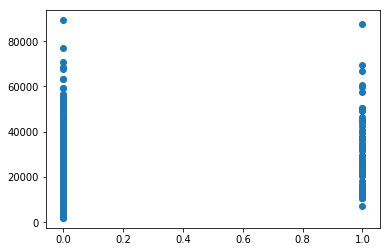

In [8]:
# plot some graphs
plt.scatter(model_train_X['First'], model_train_y)

In [9]:
# subsetting the training dataset
print model_train_X[0:3]
drop_cols = ['Season', 'Game_ID','Game_Date', 'Away_Team', 'Home_Team']

# make train set of 1200
model_sub_X = model_train_X.drop(drop_cols, axis=1)[0 : 1500]
model_sub_y = model_train_y[0 : 1500]

# make validation set that we will use to optimise our model
model_val_X = model_train_X.drop(drop_cols, axis=1)[1500 : 1750]
model_val_y = model_train_y[1500 : 1750]

# make test set that we won't touch until we're completely done
model_test_X = model_train_X.drop(drop_cols, axis=1)[1750 : ]
model_test_y = model_train_y[1750 : ]


    Season   Game_ID   Game_Date Away_Team Home_Team  Year  Rivalry  Day_Code  \
0  2016-17  21600001  10/25/2016       NYK       CLE     0        0         1   
1  2016-17  21600003  10/25/2016       SAS       GSW     0        0         1   
2  2016-17  21600002  10/25/2016       UTA       POR     0        0         1   

   Holiday  First      ...       Home_Market_Size  Away_Market_Size  \
0        0      1      ...                 4053.0           19995.0   
1        0      1      ...                 6750.0            2193.0   
2        0      1      ...                 3010.0            2505.0   

   Home_Championships  Away_Championships  Home_Playoffs  Away_Playoffs  \
0                 1.0                 2.0            7.0            5.0   
1                 4.0                 5.0            5.0           16.0   
2                 1.0                 0.0            9.0            8.0   

   Home_Twitter  Away_Twitter  Home_Win_Pct  Away_Win_Pct  
0         1.138         1.393

In [10]:
def mape(predict, actual):
    n = len(predict)
    sum_score = 0.0
    for i in xrange(n):
        sum_score += abs(predict[i] - actual[i]) / float(actual[i])
    return (1 / float(len(predict))) * sum_score


In [11]:
# define regression model builder
def reg_model(model):
    print str(model)
    reg = model
    reg.fit(model_sub_X, model_sub_y)
    model_val_pred = reg.predict(model_val_X)
    print model_val_pred[0:3], model_val_y[0:3]
    print "Mape:", mape(model_val_pred, model_val_y)
    print "R2:", r2_score(model_val_y, model_val_pred)
    print '\n'
    return model_val_pred

# linear regression
linear = reg_model(linear_model.LinearRegression())


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
[ 15430.70915474  13065.46267365  19084.03255109] [15158, 12349, 17122]
Mape: 0.492047704521
R2: 0.429021958035




/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [17]:
# try random forest
reg = RandomForestRegressor(max_depth=10, random_state=0)
reg.fit(model_sub_X, model_sub_y)
print list(model_sub_X)
print(reg.feature_importances_ * 100)
model_val_pred = reg.predict(model_val_X)
print model_val_pred[0:3], model_val_y[0:3]
print "MAPE:", mape(model_val_pred, model_val_y)
print "R2", r2_score(model_val_y, model_val_pred)
rf = model_val_pred


['Year', 'Rivalry', 'Day_Code', 'Holiday', 'First', 'Last', 'Home_All_Stars', 'Away_All_Stars', 'Home_Market_Size', 'Away_Market_Size', 'Home_Championships', 'Away_Championships', 'Home_Playoffs', 'Away_Playoffs', 'Home_Twitter', 'Away_Twitter', 'Home_Win_Pct', 'Away_Win_Pct']
[  0.86924209   0.84112628   2.47989987   0.29946806   5.24765296
   0.07236605  14.04042995  24.91962259   3.12545023   2.90636529
   1.60804042   2.42492003   1.8949626    1.96148084  10.092176
   8.65978652  10.1554501    8.40156012]
[  9976.4400385   14881.44228506  15185.68062413] [15158, 12349, 17122]
MAPE: 0.402768376074
R2 0.632771791073


In [18]:
# try some other models
dt = reg_model(tree.DecisionTreeRegressor()) # Decision Tree
nb = reg_model(GaussianNB()) # naive bayes
svr = reg_model(SVR(C=1.0, epsilon=0.2)) # support vector machine
mlp = reg_model(MLPRegressor()) # multi layer perceptron
ridge = reg_model(Ridge(alpha=1.0)) # ridge regression


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
[ 14695.  10052.   6898.] [15158, 12349, 17122]
Mape: 0.484235892807
R2: 0.307171384207


GaussianNB(priors=None)
[10662 10662 11563] [15158, 12349, 17122]
Mape: 0.51346799612
R2: 0.0744095589703


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[ 14616.86622381  14618.64050591  14616.89314353] [15158, 12349, 17122]
Mape: 0.629625926293
R2: -0.0129798629201


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.

/usr/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [19]:
# combine models (does not improve model right now)
a = (linear + rf + ridge) / 3
print mape(a, model_val_y)
print r2_score(model_val_y, a)


0.436217603658
0.562481324645


In [20]:
# predict final values for output (test) set 
final_model_train_X = model_train_X.drop(drop_cols, axis=1)
final_model_output_X = model_output_X.drop(drop_cols, axis=1)

# choose which model to use
reg = RandomForestRegressor(max_depth=11, random_state=0)

# train and predict
reg.fit(final_model_train_X, model_train_y)
model_output_pred = reg.predict(final_model_output_X)

final_model_output_pred = []
# round output values
for total in model_output_pred:
    final_model_output_pred.append(round(total, 3))
    
print final_model_output_pred[0:3], len(final_model_output_pred)


[17527.057, 29529.6, 36075.175] 460


In [22]:
new_df = test_df.drop(['Total_Viewers'], axis=1)
new_df['Total_Viewers'] = final_model_output_pred

print new_df[0:3]
new_df.to_csv('test_set_Columbia.csv')


    Season   Game_ID   Game_Date Away_Team Home_Team  Total_Viewers
0  2016-17  21600010  10/26/2016       DEN       NOP      17527.057
1  2016-17  21600023  10/28/2016       HOU       DAL      29529.600
2  2016-17  21600027  10/29/2016       BOS       CHA      36075.175
